<a href="https://colab.research.google.com/github/Alim20022004/FederatedLearning/blob/main/FEDlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install medmnist
!pip -q install flwr[simulation]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 36.9 MB/s eta 0:00:00

In [ ]:
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from medmnist import PathMNIST
import flwr as fl
from typing import Dict, List, Tuple
from flwr.common import Context, Metrics
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Status,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import log
from flwr.common import Scalar,NDArrays
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Flower {fl.__version__}")


Flower 1.18.0


# `1.Define THE  MODEL`

In [ ]:
num_classes = 9
w=EfficientNet_B0_Weights.IMAGENET1K_V1
modeleff = efficientnet_b0(weights=w)
modeleff.classifier[1] = nn.Linear(modeleff.classifier[1].in_features, num_classes)
modelefficient=modeleff.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 187MB/s]


# `2.Traning & validation Function`

In [ ]:

def train_epoch(model, train_loader):
    """Train model for one epoch."""
    model.train()#train model
    correct, total, running_loss = 0,0,0.0
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.squeeze().to(device)
        optimizer.zero_grad() # Clear gradients
        outputs = model(inputs)# Forward pass
        loss = criterion(outputs, labels)# Compute loss
        loss.backward() # Backward pass (compute gradients)
        optimizer.step()# Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    return train_loss, train_acc


def validate(model, val_loader):
    """Validate model on validation set."""
    model.eval() # Set the model to evaluation mode
    correct, total, val_loss = 0,0,0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.squeeze().to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)# Compute loss

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1) # Get predicted class
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    return val_loss, val_acc


# `3.Evaluation THE Model`

In [ ]:

def evaluate_model(model, test_loader):
    """Evaluate model on test set and return predictions/labels."""
    model.eval()
    total = 0
    correct = 0
    test_loss = 0.0
    all_preds = []
    all_labels = []
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device),labels.squeeze().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    return test_loss,test_acc,np.array(all_preds), np.array(all_labels)

# `4.Lead THE DATASET`

In [ ]:

# Set random seeds for reproducibility
torch.manual_seed(42)
NUM_CLIENTS = 5
BATCH_SIZE = 64


In [ ]:
def load_full_datasets():
    """
    Load the complete PathMNIST dataset splits with appropriate transformations.

    Returns:
        tuple: (train_dataset, val_dataset, test_dataset)
    """
    # Transformations for training data (with augmentation)
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Transformations for validation and testing (without augmentation)
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load the full datasets
    train_dataset = PathMNIST(split='train', transform=train_transform, download=True)
    val_dataset = PathMNIST(split='val', transform=test_transform, download=True)
    return train_dataset, val_dataset

In [ ]:
def load_test_dataset():
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    test_dataset = PathMNIST(split='test', transform=test_transform, download=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    return test_loader


In [ ]:
def partition_dataset(dataset, num_partitions: int):
    # Shuffle dataset indices randomly
    indices = np.random.permutation(len(dataset))
    # Split indices into num_partitions parts
    partitions_indices = np.array_split(indices, num_partitions)
    # Create a Subset for each partition
    subsets = [Subset(dataset, idx) for idx in partitions_indices]
    return subsets

In [ ]:
# --- Perform data loading and partitioning ONCE globally ---
print("Loading and partitioning datasets globally...")
start_time_data_prep = time.time()

# 1. Load full datasets once
FULL_TRAIN_DATASET, FULL_VAL_DATASET = load_full_datasets()
print(f"Full train dataset size: {len(FULL_TRAIN_DATASET)}")
print(f"Full val dataset size: {len(FULL_VAL_DATASET)}")
# 2. Partition them once
# Choose your partitioning strategy (e.g., Non-IID)
TRAIN_PARTITIONS = partition_dataset(FULL_TRAIN_DATASET, NUM_CLIENTS)
print(f"Train partitions: {len(TRAIN_PARTITIONS)}")

VAL_PARTITIONS = partition_dataset(FULL_VAL_DATASET, NUM_CLIENTS)
print(f"Val partitions: {len(VAL_PARTITIONS)}")
# Or for IID:
# TRAIN_PARTITIONS = partition_dataset(FULL_TRAIN_DATASET, NUM_CLIENTS)
# VAL_PARTITIONS = partition_dataset(FULL_VAL_DATASET, NUM_CLIENTS)

end_time_data_prep = time.time()
print(f"Data loaded and partitioned for {NUM_CLIENTS} clients in {end_time_data_prep - start_time_data_prep:.2f} seconds.")



Loading and partitioning datasets globally...


100%|██████████| 206M/206M [00:11<00:00, 18.1MB/s]


Full train dataset size: 89996
Full val dataset size: 10004
Train partitions: 5
Val partitions: 5
Data loaded and partitioned for 5 clients in 15.00 seconds.


In [ ]:
print(TRAIN_PARTITIONS[0])
print(VAL_PARTITIONS[0])

Visualizing data distribution for 5 clients...


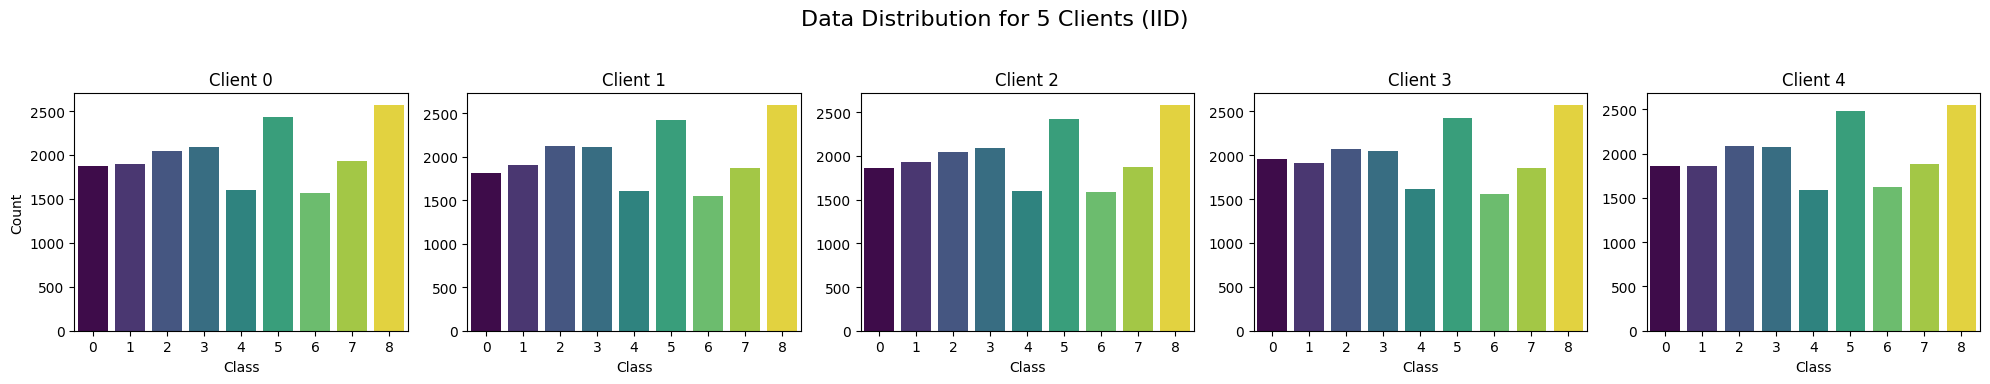

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Ensure numpy is imported

# Assume these global variables are defined and populated as in your main script:
# NUM_CLIENTS
# FULL_TRAIN_DATASET
# TRAIN_PARTITIONS
# num_classes

def visualize_client_data_distribution(): # Using global variables as per previous structure
    """
    Visualize the distribution of dataset categories for each client.
    Adapts layout for NUM_CLIENTS = 5 or NUM_CLIENTS = 10.
    Uses global variables NUM_CLIENTS, FULL_TRAIN_DATASET, TRAIN_PARTITIONS, num_classes.
    """
    global NUM_CLIENTS, FULL_TRAIN_DATASET, TRAIN_PARTITIONS, num_classes # Explicitly declare usage of globals

    print(f"Visualizing data distribution for {NUM_CLIENTS} clients...")

    if NUM_CLIENTS == 5:
        nrows = 1
        ncols = 5
        figsize = (20, 4)
    elif NUM_CLIENTS == 10:
        nrows = 2
        ncols = 5
        figsize = (20, 8) # (width, height)
    elif NUM_CLIENTS == 1:
        nrows = 1
        ncols = 1
        figsize = (5, 4)
    else:
        # Default layout for other numbers of clients (as in previous version)
        # This part handles cases other than 1, 5, or 10
        ncols_default = min(NUM_CLIENTS, 5) # Max 5 columns, or fewer if fewer clients
        nrows_default = (NUM_CLIENTS + ncols_default - 1) // ncols_default
        figsize = (min(20, ncols_default * 4), nrows_default * 4)
        nrows, ncols = nrows_default, ncols_default # Assign to nrows, ncols for consistency
        print(f"Using default layout: {nrows} rows, {ncols} columns for {NUM_CLIENTS} clients.")


    # squeeze=False ensures axs is always 2D, making .flatten() safe
    fig, axs_grid = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    axs = axs_grid.flatten() # Flatten to iterate easily

    for i in range(NUM_CLIENTS):
        if i >= len(axs): # Should not happen if nrows, ncols are calculated correctly
            print(f"Warning: Not enough subplots for client {i}. Skipping.")
            break
        ax = axs[i] # Current subplot

        subset_indices = TRAIN_PARTITIONS[i].indices

        labels = []
        for idx in subset_indices:
            # Accessing labels (assuming PathMNIST structure or similar)
            # dataset[idx] gives (image, label_tensor)
            # label_tensor.item() gives the Python number
            label_val = FULL_TRAIN_DATASET.targets[idx] if hasattr(FULL_TRAIN_DATASET, 'targets') else FULL_TRAIN_DATASET[idx][1]
            if hasattr(label_val, 'item'):
                label_val = label_val.item()
            labels.append(int(label_val))

        counts = [labels.count(cls) for cls in range(num_classes)]

        sns.barplot(
            x=list(range(num_classes)),
            y=counts,
            hue=list(range(num_classes)), # Not strictly necessary if x defines the groups
            ax=ax,
            palette="viridis",
            legend=False # No legend if hue is not used distinctively
        )
        ax.set_title(f'Client {i}')
        ax.set_xlabel('Class')

        # Only show Y-axis label for the first plot in each row
        if i % ncols == 0:
            ax.set_ylabel('Count')
        else:
            ax.set_ylabel('') # Clear y-label for other plots in the row

    # Hide any unused subplots if NUM_CLIENTS is not a perfect multiple of ncols
    for j in range(NUM_CLIENTS, nrows * ncols):
        if j < len(axs): # Check index bounds
            fig.delaxes(axs[j])

    plt.suptitle(f'Data Distribution for {NUM_CLIENTS} Clients (IID)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()
visualize_client_data_distribution()

In [ ]:
def load_client_dataloaders(partition_id: int):
    """
    Creates DataLoaders for a specific client using pre-partitioned global data.
    """
    if not (0 <= partition_id < NUM_CLIENTS):
        raise ValueError(f"Partition ID {partition_id} is out of bounds for {NUM_CLIENTS} clients.")

    client_train_subset = TRAIN_PARTITIONS[partition_id]
    client_val_subset = VAL_PARTITIONS[partition_id]

    train_loader = DataLoader(client_train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True if device.type == "cuda" else False)
    val_loader = DataLoader(client_val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True if device.type == "cuda" else False)
    return train_loader, val_loader

# 6.Federated Learning With FLOWER

In [ ]:
def get_parameters(model) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in model.state_dict().items()]


def set_parameters(model, parameters: List[np.ndarray]):
    params_dict = zip(model.state_dict().keys(), parameters) # k ,v
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict)#updated

### 6.1. Define the Flower ClientApp

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self,partition_id,model, train_loader, val_loader):
        self.partition_id = partition_id
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader


    def get_parameters(self, config) :
        #get the model parameters and return them as a list of NumPy ndarray’s
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.model)

    def fit(self, parameters: List[np.ndarray], config: Dict) -> Tuple[List[np.ndarray], int, Dict]:
        print(f"[Client {self.partition_id}] fit")
        train_start_time = time.time()
        set_parameters(self.model, parameters)
        # Start timing the training process
        train_loss, train_acc = train_epoch(self.model, self.train_loader)
        # End timing the training process
        train_end_time = time.time()
        train_duration = train_end_time - train_start_time
        print(f"Client training duration {train_duration}")
        return self.get_parameters({}), len(self.train_loader),{"train_duration": train_duration}

    def evaluate(self, parameters: List[np.ndarray], config: Dict) -> Tuple[float, int, Dict]:
        print(f"[Client {self.partition_id}] evaluate")
        set_parameters(self.model, parameters)
        val_loss, val_acc = validate(self.model, self.val_loader)
        return float(val_loss), len(self.val_loader), {"val_acc": float(val_acc)}

In [ ]:
class FlowerClientcustom(Client):
    def __init__(self, partition_id, model, train_loader, val_loader):
        self.partition_id = partition_id
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader

    def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
        print(f"[Client {self.partition_id}] get_parameters")

        # Get parameters as a list of NumPy ndarray's
        ndarrays: List[np.ndarray] = get_parameters(self.model)

        # Serialize ndarray's into a Parameters object
        parameters = ndarrays_to_parameters(ndarrays)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(
            status=status,
            parameters=parameters,
        )

    def fit(self, ins: FitIns) -> FitRes:
        print(f"[Client {self.partition_id}] fit")
        train_start_time = time.time()
        # Deserialize parameters to NumPy ndarray's
        parameters_original = ins.parameters
        ndarrays_original = parameters_to_ndarrays(parameters_original)

        # Update local model, train, get updated parameters
        set_parameters(self.model, ndarrays_original)
        train_loss, train_acc = train_epoch(self.model, self.train_loader)
        print(f"Train accuracy : {train_acc}| Train loss :{train_loss}")
        ndarrays_updated = get_parameters(self.model)

        # Serialize ndarray's into a Parameters object
        parameters_updated = ndarrays_to_parameters(ndarrays_updated)
        train_end_time = time.time()
        train_duration = train_end_time - train_start_time
        print(f"Client training duration {train_duration}")

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.train_loader),
            metrics={"train_duration": train_duration},
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        print(f"[Client {self.partition_id}] evaluate")
        # Deserialize parameters to NumPy ndarray's
        parameters_original = ins.parameters
        ndarrays_original = parameters_to_ndarrays(parameters_original)
        set_parameters(self.model, ndarrays_original)
        val_loss, val_acc = validate(self.model, self.val_loader)
        print(f"Val accuracy : {val_acc}| val loss :{val_loss}")
        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(val_loss),
            num_examples=len(self.val_loader),
            metrics={"val_acc": float(val_acc)},
        )


In [ ]:
def client_fn(context: Context) ->Client:
    """Create Flower client with partition ID."""
    model=modelefficient
    partition_id = context.node_config["partition-id"]
    train_loader, val_loader =load_client_dataloaders(partition_id)
    print(f"Client {partition_id} initialized. Train samples: {len(train_loader.dataset)}, Val samples: {len(val_loader.dataset)}")
    return FlowerClientcustom(partition_id,model,train_loader, val_loader).to_client()

client_app = ClientApp(client_fn=client_fn)



### 6.2 function Aggregation validation/test accuracy

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
   # Aggregate validation accuracy
    val_accs = [num_examples * m["val_acc"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    return {"val_acc": sum(val_accs) / sum(examples)}

def simple_avg_training_time(metrics):
    avg_time = sum(m["train_duration"] for _, m in metrics) / len(metrics)
    return {"avg_training_time": avg_time}

test_loader = load_test_dataset()
def evaluate_fn(
        server_round: int, parameters: NDArrays, config: Dict[str,Scalar],
    ) -> Tuple[float, Dict[str, Scalar]]:
        model = modelefficient
        set_parameters(model, parameters)
        test_loss, test_acc, _, _ = evaluate_model(model, test_loader)
        print(f"Global Test Accuracy (Round {server_round}): {test_acc:.2f}%")
        return test_loss, {"test_acc": test_acc }

### 6.4. Define the Flower ServertApp

In [ ]:

# Create an instance of the model and get the parameters
params =get_parameters(modeleff)
# Global variables for timing data
round_times = []
aggregation_times = []

def server_fn(context: Context) -> ServerAppComponents:
    global round_times, aggregation_times
    # Reset timing data for each simulation
    round_times = []
    aggregation_times = []

    class CustomFedAvg(FedAvg):
        def configure_fit(self, server_round, parameters, client_manager):
            global round_times, aggregation_times
            self.round_start_time = time.time()
            return super().configure_fit(server_round, parameters, client_manager)

        def aggregate_fit(self, server_round, results, failures):
            global round_times, aggregation_times
            agg_start = time.time()
            aggregated = super().aggregate_fit(server_round, results, failures)
            agg_duration = time.time() - agg_start

            if not failures:
                aggregation_times.append((server_round, agg_duration))
                round_times.append((server_round, time.time() - self.round_start_time))
            return aggregated

    strategy = CustomFedAvg(
        fraction_fit=1,
        fraction_evaluate=0,
        min_available_clients=NUM_CLIENTS,
        fit_metrics_aggregation_fn=simple_avg_training_time,
        evaluate_fn=evaluate_fn,
        initial_parameters=ndarrays_to_parameters(params),
        #evaluate_metrics_aggregation_fn=weighted_average,
    )

    config = ServerConfig(num_rounds=10)
            # Wrap server execution in a try-except block
    try:
        components = ServerAppComponents(strategy=strategy, config=config)
        # Run some initial checks for configuration issues
        print("Initial parameters shape:", [p.shape for p in params])
        print("Initial parameters type:", [p.dtype for p in params])
        return components
    except Exception as e:
        print(f"Error during server initialization or execution: {e}")
        raise e  # Re-raise the exception for traceback
    return ServerAppComponents(strategy=strategy, config=config)

# Create the ServerApp
server_app = ServerApp(server_fn=server_fn)

In [ ]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 2, "num_gpus": 1.0 }}


### 6.5. Run Flower SIMULATION

In [ ]:
# Start simulation
run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
    )


In [ ]:
def plot_time_curve():

    global round_times, aggregation_times

    if not round_times:
        print("No timing data collected during simulation.")
        return

    # Extract rounds and times
    rounds = [r for r, _ in round_times]
    times = [t for _, t in round_times]
    cumulative_times = np.cumsum(times)  # Compute cumulative time

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, cumulative_times, marker='o', linestyle='-', color='b', label='Cumulative Time')
    plt.xlabel('Number of Rounds')
    plt.ylabel('Cumulative Time (seconds)')
    plt.title('Cumulative Time Taken vs. Number of Rounds (Client Training and Aggregation)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Display total time
    print(round_times)
    total_time = cumulative_times[-1]
    print(f"Total time taken for {len(rounds)} rounds (client training and aggregation): {total_time:.2f} seconds")
    avg_duration = sum(duration for _, duration in round_times) / len(round_times)
    print(f"Average round duration: {avg_duration:.2f} seconds")
    print(aggregation_times)
    avg_aggregation_time = sum(duration for _, duration in aggregation_times) / len(aggregation_times)
    print(f"Average aggregation time: {avg_aggregation_time:.2f} seconds")
plot_time_curve()
